<a href="https://colab.research.google.com/github/cekbote/pytorch-tutorials/blob/master/4_Training_Deep_Neural_Networks_on_a_GPU_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks on a GPU with PyTorch

## Preparing the Data

In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [6]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [7]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [9]:
# Creating PyTorch data loaders
# Dataloader docs:  https://pytorch.org/docs/stable/data.html

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, 
                          pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, 
                        pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


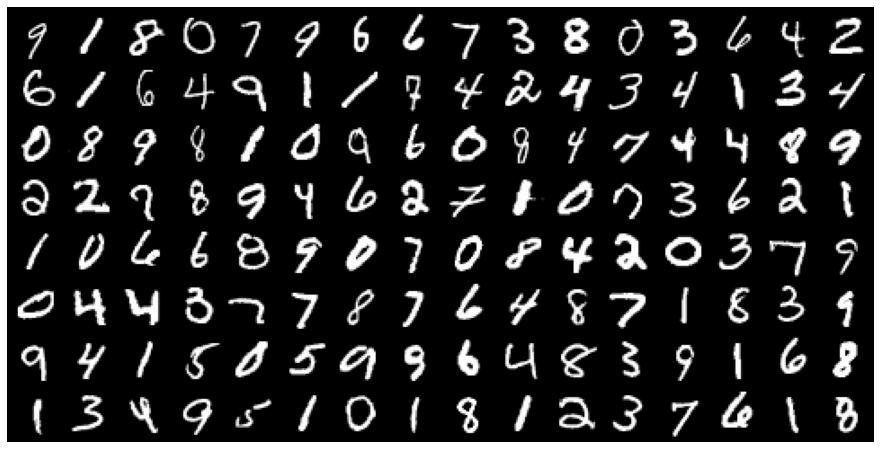

In [10]:
# Let's visualize a batch of data in a grid using the make_grid function from 
# torchvision. We'll also use the .permute method on the tensor to move the 
# channels to the last dimension, as expected by matplotlib.

for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model
To improve upon logistic regression, we'll create a neural network with one hidden layer. Here's what this means:

- Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.

- The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size, where hidden_size is a preconfigured parameter (e.g. 32 or 64).

- The intermediate outputs are then passed into a non-linear activation function, which operates on individual elements of the output matrix.

- The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size batch_size x 10, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. 